In [ ]:
import snowflake.connector
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dotenv as dot
from sqlalchemy import create_engine
# from dotenv import load_dotenv

DATABASE_SCHEMA = 'EVENT.DATATHON_2025_TEAM_ETA'

def get_snowflake_connection():
    '''
    Create a connection to Snowflake using credentials from .env file
    '''
    # Load environment variables
    dot.load_dotenv()
    
    # Get connection parameters from environment variables
    conn = snowflake.connector.connect(
        account=os.getenv('SNOWFLAKE_ACCOUNT'),
        user=os.getenv('SNOWFLAKE_USER'),
        password=os.getenv('SNOWFLAKE_PASSWORD'),
        role=os.getenv('SNOWFLAKE_ROLE'),
        warehouse=os.getenv('SNOWFLAKE_WAREHOUSE'),
        database=os.getenv('SNOWFLAKE_DATABASE'),
        schema=os.getenv('SNOWFLAKE_SCHEMA')
    )
    
    return conn

def query_to_df(query):
    '''
    Execute a query and return the results as a pandas DataFrame
    '''
    conn = get_snowflake_connection()
    cursor = conn.cursor()
    cursor.execute(query)

    # Get column names
    columns = [col[0] for col in cursor.description]

    # Fetch all rows and convert to list of dictionaries
    results = [dict(zip(columns, row)) for row in cursor.fetchall()]

    cursor.close()
    conn.close()

    return pd.DataFrame(results)

def upload_csv_to_snowflake(dataframe, table_name):
    
    conn = get_snowflake_connection()
    cursor = conn.cursor()
    
    engine = create_engine(
        f'snowflake://{conn.user}:{os.getenv('SNOWFLAKE_PASSWORD')}@{conn.account}/{conn.database}/{conn.schema}?warehouse={conn.warehouse}'
    )
    dataframe.to_sql(
        name=table_name,
        con=engine,
        schema=conn.schema,
        if_exists='replace',
        index=False,
        method='multi'
    )
    
    # Get row count
    cursor = conn.cursor()
    cursor.execute(f'SELECT COUNT(*) FROM {conn.database}.{conn.schema}.{table_name}')
    row_count = cursor.fetchone()[0]
    cursor.close()
    conn.close()
    
    return row_count
    

# Example status_df 
status = query_to_df(f'SELECT * FROM {DATABASE_SCHEMA}.status')
print(status.head())

   STATUSID        STATUS
0         1      Finished
1         2  Disqualified
2         3      Accident
3         4     Collision
4         5        Engine


In [ ]:
# Create a master dataset from circuits, drivers, races, constructors, status, results

circuits = query_to_df(f'SELECT * FROM {DATABASE_SCHEMA}.CIRCUITS')
drivers = query_to_df(f'SELECT * FROM {DATABASE_SCHEMA}.DRIVERS')

races = query_to_df(f'SELECT * FROM {DATABASE_SCHEMA}.RACES')
races = races.rename(columns={'NAME': 'RACE_NAME'})

constructors = query_to_df(f'SELECT * FROM {DATABASE_SCHEMA}.CONSTRUCTORS')
constructors = constructors.rename(columns={'NAME': 'CONSTRUCTOR_NAME'})
constructors = constructors.rename(columns={'NATIONALITY': 'CONSTRUCTOR_NATIONALITY'})

results = query_to_df(f'SELECT * FROM {DATABASE_SCHEMA}.RESULTS')


main_df = results.merge(races, on='RACEID', suffixes=('', '_race')).merge(
    drivers, 
    on='DRIVERID', 
    suffixes=('', '_DRIVER')
).merge(
    constructors, 
    on='CONSTRUCTORID', 
    suffixes=('', '_CONSTRUCTOR')
).merge(
    status, 
    on='STATUSID', 
    suffixes=('', '_STATUS')
).merge(
    circuits,
    on='CIRCUITID',
    suffixes=('', 'CIRCUIT')
)

print(f'Number of duplicate {main_df.duplicated().sum()}')
print(main_df.shape)
print(main_df.columns)
print(main_df.info())

Number of duplicate 0
(26759, 51)
Index(['RESULTID', 'RACEID', 'DRIVERID', 'CONSTRUCTORID', 'NUMBER', 'GRID',
       'POSITION', 'POSITIONTEXT', 'POSITIONORDER', 'POINTS', 'LAPS', 'TIME',
       'MILLISECONDS', 'FASTESTLAP', 'RANK', 'FASTESTLAPTIME',
       'FASTESTLAPSPEED', 'STATUSID', 'YEAR', 'ROUND', 'CIRCUITID',
       'RACE_NAME', 'DATE', 'TIME_race', 'FP1_DATE', 'FP1_TIME', 'FP2_DATE',
       'FP2_TIME', 'FP3_DATE', 'FP3_TIME', 'QUALI_DATE', 'QUALI_TIME',
       'SPRINT_DATE', 'SPRINT_TIME', 'FULL_NAME', 'DOB', 'NATIONALITY', 'WINS',
       'CONSTRUCTOR_NAME', 'CONSTRUCTOR_NATIONALITY', 'STATUS', 'NAME',
       'LOCATION', 'COUNTRY', 'LAT', 'LNG', 'ALT', 'ALTITUDE_CATEGORY',
       'ESTIMATED_LENGTH_KM', 'AVG_RACE_LAPS', 'ESTIMATED_RACE_DISTANCE_KM'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26759 entries, 0 to 26758
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      ----------

In [54]:
# Filter for 2014-Now

filter_df = main_df[main_df['YEAR'] >=2014].copy()

print(filter_df.shape)
print(filter_df.columns)
print(filter_df.info())


(4626, 51)
Index(['RESULTID', 'RACEID', 'DRIVERID', 'CONSTRUCTORID', 'NUMBER', 'GRID',
       'POSITION', 'POSITIONTEXT', 'POSITIONORDER', 'POINTS', 'LAPS', 'TIME',
       'MILLISECONDS', 'FASTESTLAP', 'RANK', 'FASTESTLAPTIME',
       'FASTESTLAPSPEED', 'STATUSID', 'YEAR', 'ROUND', 'CIRCUITID',
       'RACE_NAME', 'DATE', 'TIME_race', 'FP1_DATE', 'FP1_TIME', 'FP2_DATE',
       'FP2_TIME', 'FP3_DATE', 'FP3_TIME', 'QUALI_DATE', 'QUALI_TIME',
       'SPRINT_DATE', 'SPRINT_TIME', 'FULL_NAME', 'DOB', 'NATIONALITY', 'WINS',
       'CONSTRUCTOR_NAME', 'CONSTRUCTOR_NATIONALITY', 'STATUS', 'NAME',
       'LOCATION', 'COUNTRY', 'LAT', 'LNG', 'ALT', 'ALTITUDE_CATEGORY',
       'ESTIMATED_LENGTH_KM', 'AVG_RACE_LAPS', 'ESTIMATED_RACE_DISTANCE_KM'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 4626 entries, 22127 to 26758
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   RESULT

                 Missing Values  Percent Missing
SPRINT_TIME                4326        93.514916
SPRINT_DATE                4266        92.217899
FP3_TIME                   3567        77.107652
FP1_TIME                   3267        70.622568
FP2_TIME                   3267        70.622568
QUALI_TIME                 3267        70.622568
FP3_DATE                   3187        68.893212
FP1_DATE                   2827        61.111111
FP2_DATE                   2827        61.111111
QUALI_DATE                 2827        61.111111
MILLISECONDS               2219        47.968007
TIME                       2219        47.968007
POSITION                    721        15.585819
FASTESTLAPTIME              217         4.690878
FASTESTLAP                  217         4.690878
FASTESTLAPSPEED             217         4.690878


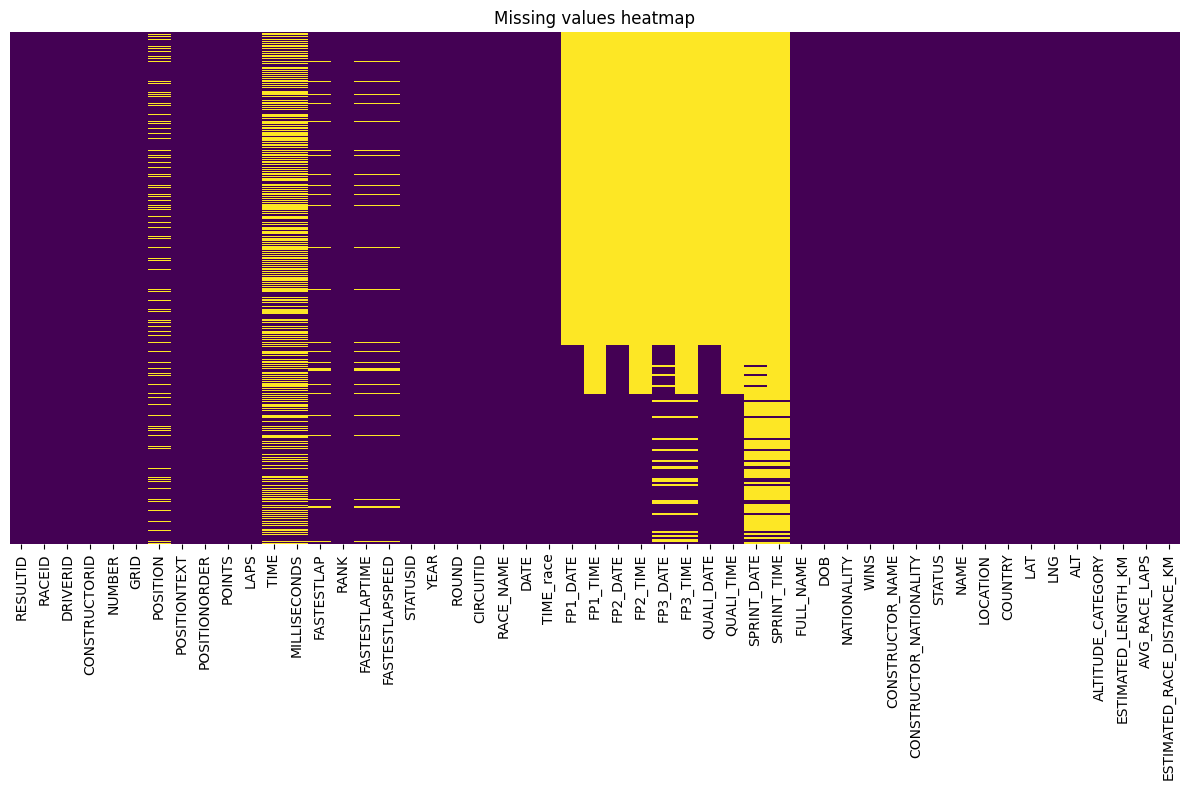

In [55]:
def missing_vals_analysis(df):
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Values': missing_values,
        'Percent Missing': missing_percent
    })
    print(missing_df[missing_df['Missing Values'] > 0].sort_values('Percent Missing', ascending=False))
    plt.figure(figsize=(12,8))
    sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
    plt.title('Missing values heatmap')
    plt.tight_layout()
    plt.show()
    plt.savefig('{df}_missing_values_heatmap.png')
    plt.close()

missing_vals_analysis(filter_df)

                 Missing Values  Percent Missing
MILLISECONDS               2219        47.968007
FASTESTLAP                  217         4.690878
FASTESTLAPTIME              217         4.690878
FASTESTLAPSPEED             217         4.690878


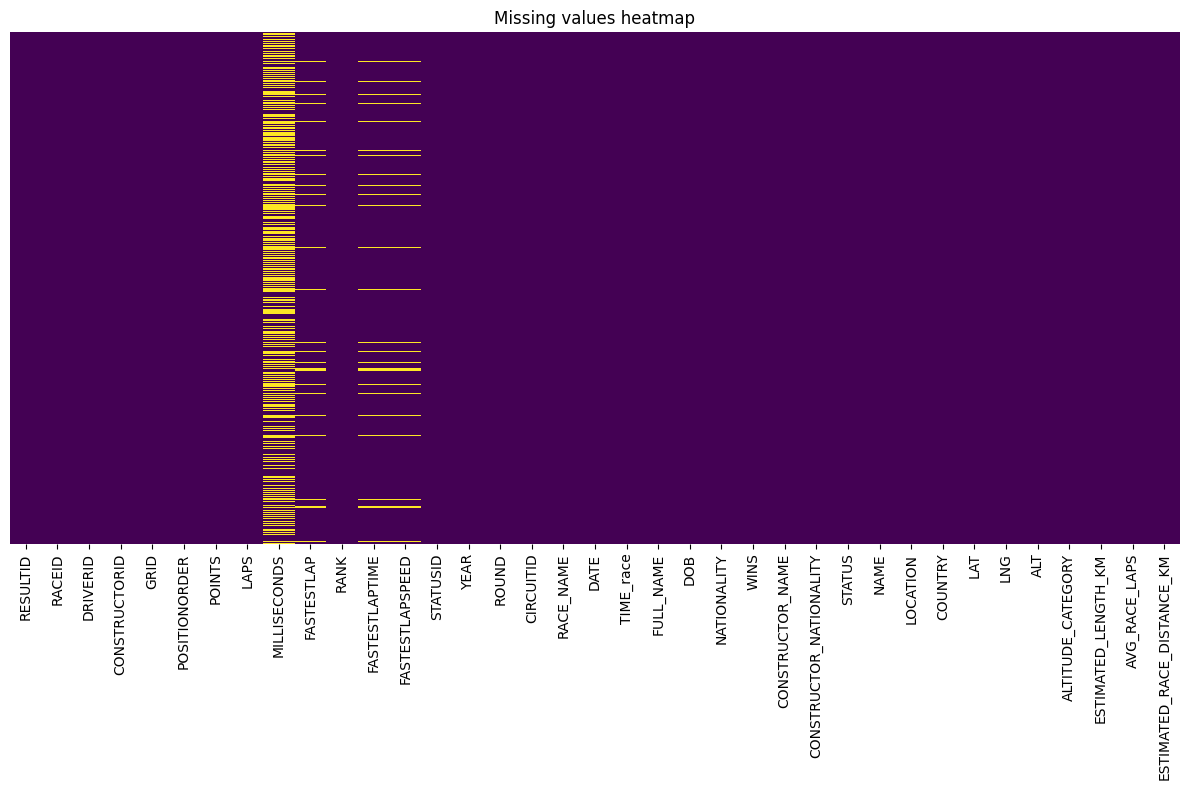

In [56]:
columns_to_drop = [
    'POSITION', 'POSITIONTEXT', 'TIME', 'NUMBER', 'SPRINT_TIME', 'SPRINT_DATE',
    'FP3_TIME', 'FP1_TIME', 'FP2_TIME', 'QUALI_TIME','FP1_DATE', 'FP3_DATE', 'FP2_DATE',
    'QUALI_DATE', 'TIME'
]

filter_df.drop(columns=columns_to_drop, inplace=True)

missing_vals_analysis(filter_df)

In [57]:
# Fixing incorrect dtypes
filter_df['POINTS'] = pd.to_numeric(filter_df['POINTS'], errors='coerce')
filter_df['FASTESTLAPSPEED'] = pd.to_numeric(filter_df['FASTESTLAPSPEED'], errors='coerce')
filter_df['LAT'] = pd.to_numeric(filter_df['LAT'], errors='coerce')
filter_df['LNG'] = pd.to_numeric(filter_df['LNG'], errors='coerce')

filter_df['DATE'] = pd.to_datetime(filter_df['DATE'], errors='coerce')
filter_df['DOB'] = pd.to_datetime(filter_df['DOB'], errors='coerce')


                 Missing Values  Percent Missing
MILLISECONDS                797        17.228707
FASTESTLAPTIME              217         4.690878
FASTESTLAP                  208         4.496325
FASTESTLAPSPEED             208         4.496325


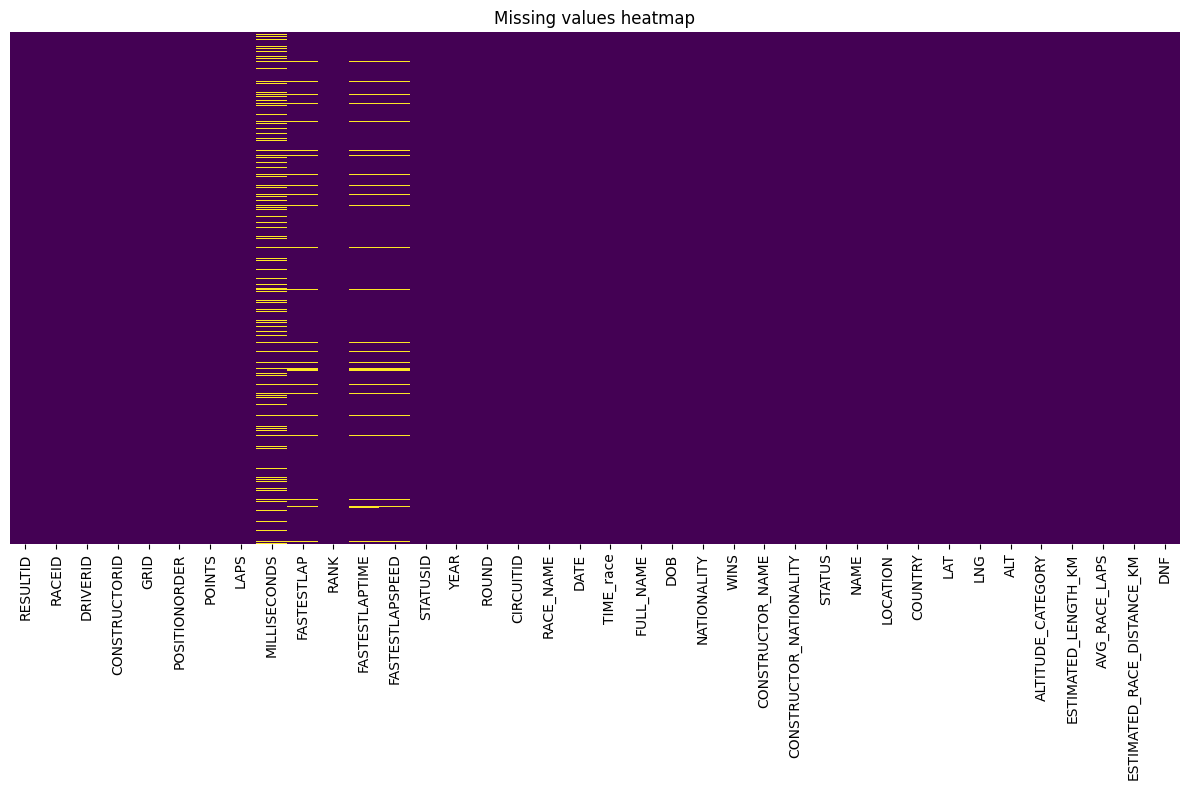

In [58]:
def race_finished(status):
    return status == 'Finished' or status.strip().startswith('+')

filter_df['DNF'] = filter_df.apply(
    lambda row: pd.isnull(row['MILLISECONDS']) and race_finished(row['STATUS']),
    axis=1)
# convert to int for modelling, 1 is didn't finish and 0 if finishd
filter_df['DNF'] = filter_df['DNF'].astype(int)

filter_df['MILLISECONDS'] = filter_df.apply(
    lambda row: 0 if pd.isna(row['MILLISECONDS']) and row['DNF'] == 1 else row['MILLISECONDS'], 
    axis=1
)
filter_df['FASTESTLAP'] = filter_df.apply(
    lambda row: 0 if pd.isna(row['FASTESTLAP']) and row['DNF'] == 1 else row['FASTESTLAP'], 
    axis=1
)
filter_df['FASTESTLAPSPEED'] = filter_df.apply(
    lambda row: 0 if pd.isna(row['FASTESTLAPSPEED']) and row['DNF'] == 1 else row['FASTESTLAPSPEED'], 
    axis=1
)
missing_vals_analysis(filter_df)

In [ ]:
print(f'Number of rows with null FASTESTLAP: {len( filter_df[filter_df['FASTESTLAP'].isnull()])}')


races_with_all_null_fastlap = filter_df.groupby(['RACEID', 'RACE_NAME', 'YEAR']).apply(
    lambda group: group['FASTESTLAP'].isnull().all()
).reset_index()

# Rename the result column
races_with_all_null_fastlap = races_with_all_null_fastlap.rename(columns={0: 'ALL_NULL_FASTLAP'})

# Filter to only show races where all drivers have null FASTESTLAP
races_with_all_null_fastlap = races_with_all_null_fastlap[races_with_all_null_fastlap['ALL_NULL_FASTLAP']]

# Check how many drivers were in each of these races
race_counts = filter_df[filter_df['RACEID'].isin(races_with_all_null_fastlap['RACEID'])].groupby(
    ['RACEID', 'RACE_NAME', 'YEAR']
).size().reset_index(name='DRIVER_COUNT')

print(race_counts.sort_values('YEAR'))
# Need to work out what we want to do with these, drop or look at reason

Number of rows with null FASTESTLAP: 71
   RACEID           RACE_NAME  YEAR  DRIVER_COUNT
0    1063  Belgian Grand Prix  2021            20


C:\Users\emily.nagle\AppData\Local\Temp\ipykernel_15108\3696082457.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  races_with_all_null_fastlap = filter_df.groupby(['RACEID', 'RACE_NAME', 'YEAR']).apply(


                 Missing Values  Percent Missing
FASTESTLAPTIME               80         1.783326
FASTESTLAP                   71         1.582702
FASTESTLAPSPEED              71         1.582702


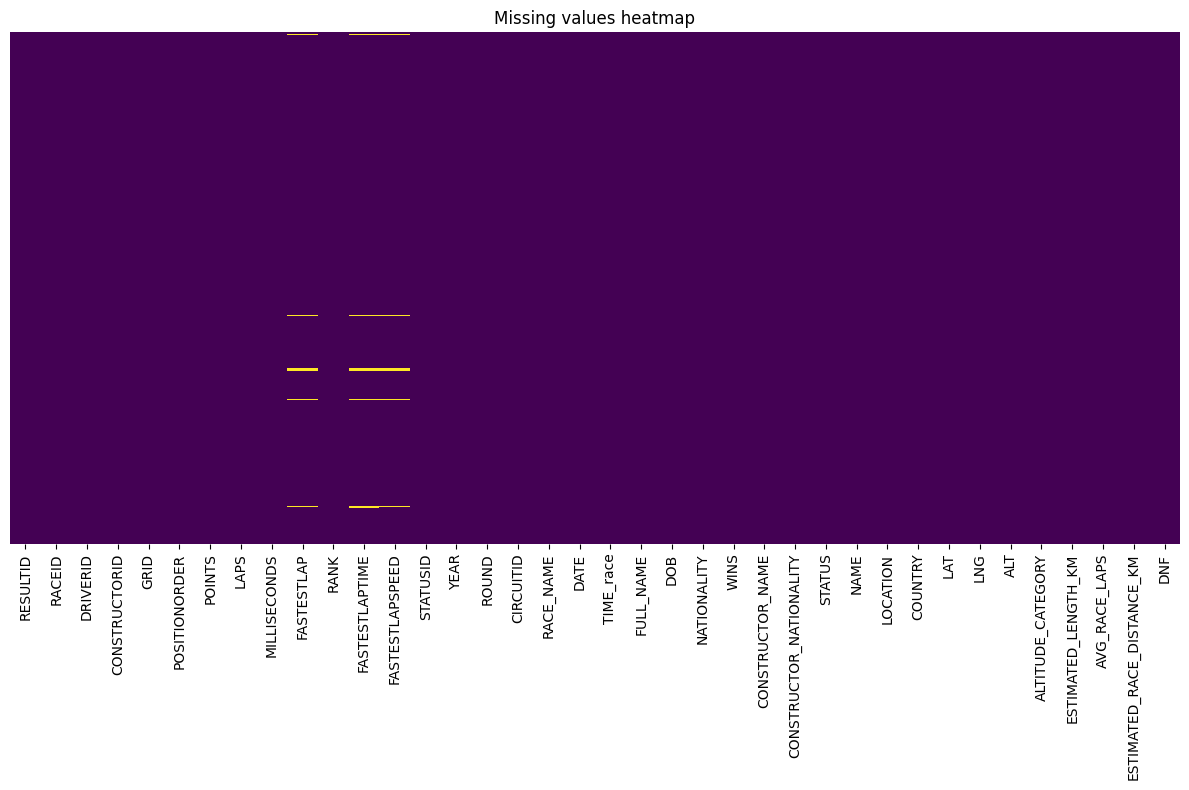

In [70]:
# for each race, grab posorder as 1 and check status is finished, grab the number of laps completed. 
# if milliseconds is null fill with 0

winners = filter_df[(filter_df['POSITIONORDER'] == 1) &( filter_df['STATUSID'] == 1)].copy()
race_winner_laps = winners[['RACEID', 'LAPS']].set_index('RACEID')['LAPS'].to_dict()

def determine_dnf(row):
    winner_laps = race_winner_laps.get(row['RACEID'])

    if pd.isnull(row['MILLISECONDS']) and row['LAPS'] < winner_laps:
        return True
    elif row['STATUS'] != 'Finished' and not str(row['STATUS']).strip().startswith('+'):
        return True
    else:
        return False

# Apply the function to create/update DNF column
filter_df['DNF'] = filter_df.apply(determine_dnf, axis=1)

# Step 3: Set milliseconds to 0 for DNF races
filter_df.loc[filter_df['DNF'] == 1, 'MILLISECONDS'] = 0

missing_vals_analysis(filter_df)

In [71]:
filter_df = filter_df[(filter_df['GRID'] <= 30) & (filter_df['LAPS'] > 0)]

print(filter_df.shape)
print(filter_df.columns)
print(filter_df.info())

(4486, 38)
Index(['RESULTID', 'RACEID', 'DRIVERID', 'CONSTRUCTORID', 'GRID',
       'POSITIONORDER', 'POINTS', 'LAPS', 'MILLISECONDS', 'FASTESTLAP', 'RANK',
       'FASTESTLAPTIME', 'FASTESTLAPSPEED', 'STATUSID', 'YEAR', 'ROUND',
       'CIRCUITID', 'RACE_NAME', 'DATE', 'TIME_race', 'FULL_NAME', 'DOB',
       'NATIONALITY', 'WINS', 'CONSTRUCTOR_NAME', 'CONSTRUCTOR_NATIONALITY',
       'STATUS', 'NAME', 'LOCATION', 'COUNTRY', 'LAT', 'LNG', 'ALT',
       'ALTITUDE_CATEGORY', 'ESTIMATED_LENGTH_KM', 'AVG_RACE_LAPS',
       'ESTIMATED_RACE_DISTANCE_KM', 'DNF'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 4486 entries, 22127 to 26757
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   RESULTID                    4486 non-null   int64         
 1   RACEID                      4486 non-null   int64         
 2   DRIVERID                    4486 non-null   int

In [ ]:
upload_csv_to_snowflake(filter_df, 'CIRCUIT_CONSTRUCTOR_DRIVER_RACE_STATUS')

C:\Users\emily.nagle\AppData\Local\Temp\ipykernel_15108\312498301.py:60: UserWarning: The provided table name 'CIRCUIT_CONSTRUCTOR_DRIVER_RACE_STATUS' is not found exactly as such in the database after writing the table, possibly due to case sensitivity issues. Consider using lower case table names.
  dataframe.to_sql(


4486

In [ ]:
# # Some extra columns that may be useful
# # Create age column
# if 'DRIVER_DOB' in filter_df.columns and 'DATE' in filter_df.columns:
#     filter_df['DRIVER_AGE'] = (pd.to_datetime(filter_df['DATE']) - pd.to_datetime(filter_df['DRIVER_DOB'])).dt.days / 365.25


# # position change column (grid vs. finish)
# if 'GRID' in filter_df.columns and 'POSITIONORDER' in filter_df.columns:
#     filter_df['POSITION_CHANGE'] = filter_df['GRID'] - filter_df['POSITIONORDER']
    
#     # 8.3: Create season points and cumulative points
# filter_df = filter_df.sort_values(['YEAR', 'DRIVERID', 'DATE'])
# filter_df['SEASON_POINTS'] = filter_df.groupby(['YEAR', 'DRIVERID'])['POINTS'].transform('cumsum')


# # 8.4: Create driver experience/ number of previous races
# filter_df['DRIVER_EXPERIENCE'] = filter_df.groupby('DRIVERID').cumcount()

# # previous DNF indicator
# filter_df['PREV_DNF'] = filter_df.groupby('DRIVERID')['DNF'].shift(1).fillna(False)


# # driver DNF rate
# filter_df['DRIVER_DNF_RATE'] = filter_df.groupby('DRIVERID')['DNF'].transform(
#     lambda x: x.expanding().mean().shift(1).fillna(0)
# )

# filter_df['CIRCUIT_DNF_RATE'] = filter_df.groupby('CIRCUITID')['DNF'].transform(
#     lambda x: x.expanding().mean().shift(1).fillna(0)
# )

# filter_df['SEASON_RACE_NUMBER'] = filter_df.groupby('YEAR')['RACEID'].transform(
#     lambda x: pd.factorize(x)[0] + 1
# )

# Driver performance on distinct circuits